# パターン認識問題を解いてみる

## パターン識別編（その3）MLP編

解説付きでコードを示しています．使い方としては

1. 上から順に読んで（重要），
2. セルを実行していってください．
3. 理解できない場合は，スタッフに質問を投げるなどしてください．
4. 理解が進んだら，自分のノートを作成し，ページにコードを真似して記述していってください．

In [1]:
import numpy as np
import matplotlib.pylab as plt

もう少し複雑な２次元の識別境界を考えてみる

In [2]:
N = 500

x = np.random.uniform(low=-1, high=1, size=(N, 2))
y = np.zeros(N)

y[x[:, 1] - np.sin(2*np.pi* x[:,0]) > 0] = 1 #適当に正弦関数で境界を引く

### これで下準備完了
(x, y) にデータが入っている．これのプロットと真の直線の関係を見てみる

(-1.0, 1.0)

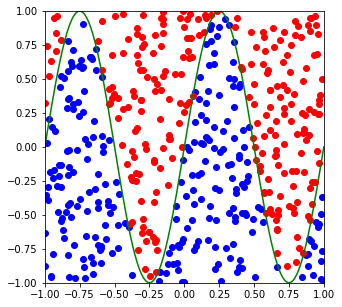

In [3]:
plt.figure(figsize=(5,5))
plt.plot(x[y==0, 0], x[y==0, 1], 'bo')
plt.plot(x[y==1, 0], x[y==1, 1], 'ro' )

xx = np.linspace(-1, 1, 128)
yy = np.sin(2*np.pi*xx)
plt.plot(xx, yy, 'g-')
plt.xlim(-1, 1)
plt.ylim(-1,1)

## 問い: 赤点と青点の境界を決めてクラスを判別することは可能か？

とりあえずのロジスティック回帰でやってみる．

$x$ が２変数からなるので， $f(x; w) = \sigma( w_1 x + w_0)$ の $w_1$ がベクトルになり $w_1 x$ の演算が内積になることのみ
ロス関数も交差エントロピー関数で
$$
    J(w) = - \sum_n y_n \log f(x_n, w) + (1-y_n) \log (1-f(x_n, w))
$$
を使う．あとは

## モデル $f(x_n; w)$ のロスが小さくなるように $w$ を求める．

## Keras + TensorFlow を用いた解法

結構時間かかります．それでいて性能はいまいちです．（まぁ線形では表現できないので当たり前なのですが）

In [4]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [5]:
# ラベルデータを tensorflow の形式に合致するよう変換 (1-hot vector 形式)

model = Sequential()   # 階層型のモデルを選択
model.add(Dense(1, input_shape=(2,), use_bias=True)) # モデルは前のやつと一緒
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',  optimizer='adam') #最適化手法を指定

In [6]:
# 学習によるパラメータフィット(時間かかります)
# Epoch 増やしてもたぶんうまくいかないと思います．
hist = model.fit(x, y, epochs=1024, batch_size=100, verbose=0)

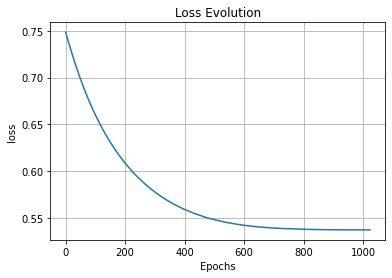

In [7]:
# ロスの値が学習によってどう変わるかを表示

plt.plot(hist.history['loss'])
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()

小さくなって収束しているように見えるけど，
ロスの値は 0.5 付近で，ほとんど小さくなっていないのであまり良くなさそう．

In [8]:
# 結合とバイアスを取り出す．

w1, w0 = model.get_weights()

w0 = float(w0)

推定直線とデータ，真の直線を重ねて見る

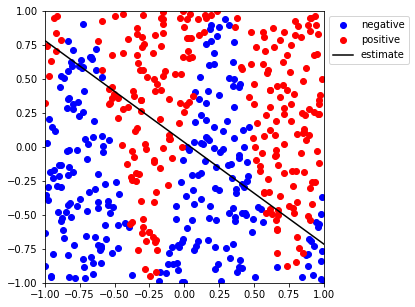

In [9]:
plt.figure(figsize=(5,5))
plt.plot(x[y==0, 0], x[y==0, 1], 'bo', label='negative')
plt.plot(x[y==1, 0], x[y==1, 1], 'ro', label='positive' )

xx = np.linspace(-1, 1, 128)
yy = - w1[0]/w1[1] * xx - w0 / w1[1]
plt.plot(xx, yy, 'k-', label='estimate')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

まぁ，識別境界が正弦波な形なので，どう頑張っても直線近似なんて無理なわけで．．．

## 多層パーセプトロン（MLP) で解く

このような複雑な境界を持つケースには，多層ニューラルネット(MLP)を使います．

MLP を構築するには，入力と出力を直接つなぐのではなく，途中に適当な大きさの中間表現を
`model.add` を用いて挿入しておきます．それでそれらの出力を使って，出力層を構築するという
枠組みになります．なので，`model.add` がちょっとだけ増えます．


なお，計算の収束にはもっと多くの時間がかかるようになります．
収束いしていないようだったら度合いを見ながら epoch を調整してみてください．

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [18]:
# モデル構築．MLP を造る
# ここでは入力2次元，中間層5次元，出力1次元のMLPを作ります．（中間層の個数は適当です）
model = Sequential()   # 階層型のモデルを選択
model.add(Dense(10, input_shape=(2,), use_bias=True))  # 入力(2次元)からの変換を5個のものに変更して中間層を構成
model.add(Activation('relu')) # 中間層を relu で非線形変換しておく(多分sigmoid でもおｋ)
model.add(Dense(10, use_bias=True))  # 入力(2次元)からの変換を5個のものに変更して中間層を構成
model.add(Activation('relu')) # 中間層を relu で非線形変換しておく(多分sigmoid でもおｋ)
model.add(Dense(1))# 前層の5個の表現を１個にまとめる（この部分は logistic 回帰のまま
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',  optimizer='adam') #最適化手法を指定

In [19]:
# 学習によるパラメータフィット
hist = model.fit(x, y, epochs=8192, batch_size=100, verbose=0)

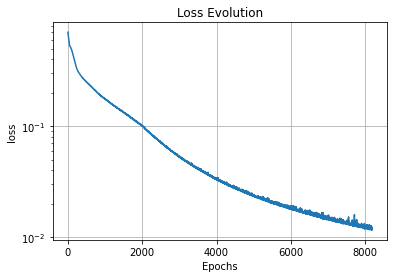

In [20]:
# ロスの値が学習によってどう変わるかを表示

#plt.plot(hist.history['loss'])
plt.semilogy(hist.history['loss'])
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()

ロスは，前よりマシになったように見えるので評価してみる

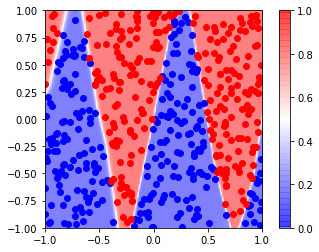

In [21]:
# meshgrid を使って [-1, 1] x[-1, 1 ] の空間に点を十分ばらまいて
# その全てを判別させる

tplus = np.linspace(-1, 1, 128)
tminus = np.linspace(1, -1, 128)
xx, yy = np.meshgrid(tplus, tminus)
xtest = np.hstack((xx.reshape(128*128, 1), yy.reshape(128*128, 1)))

# 判別には model.predict を使えばよい
plt.imshow(model.predict(xtest).reshape(128, 128), extent=[-1, 1, -1, 1], cmap='bwr', alpha=0.5)
plt.colorbar()
plt.plot(x[y==0, 0], x[y==0, 1], 'bo')
plt.plot(x[y==1, 0], x[y==1, 1], 'ro' )


歪だけど，たしかに，境界が引けているように見える．